# BMGF TTS Evaluation
* This notebook contains clean, abstracted classes to enable pipelined comparison of ML algorithms and feature sets
  

## Methods and globals
* Config saves to local temp file to reduce google requests in large sweeps
* Rerun this cell to update changes or simply pass an altnerate config file to wrappers

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import warnings
import hashlib
import pickle
import os
import json

from time import sleep
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, set_log_level, set_random_seed
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


import MeaslesDataLoader as md
import EpiPreprocessor as ep

## Environment setup

In [2]:
sb.set_context("poster")
sb.set_theme()

%matplotlib inline

warnings.simplefilter(action='ignore', category=FutureWarning)
set_log_level("ERROR")

expectedDirectories = ['input',
                       'ouput',
                       'output/figures',
                       'store']

for directory in expectedDirectories:
    if not os.path.exists(directory):
        os.makedirs(directory)

## Load / Refresh local preprocessor config copy

In [3]:
defaultConfigURL = 'https://docs.google.com/spreadsheets/d/1zn0e2-hi-p9hcOWiMk03v4TH_zq64BfD9pUgbAf1uRs/edit?usp=sharing'
preprocessorConfig = ep.getGoogleSheetConfig(defaultConfigURL)

## Utility functions

In [4]:
def prepCurve(dfIn,
              modelName,
              depVar,
              indepVars,
              configURL,
              additionalPrep = {}):
    """Prepares one curve df, paring out all unnecessary attributes"""
    # Loads preprocessor config and merges manual args
    df = dfIn.copy(True)
    config = ep.getGoogleSheetConfig(configURL)
    for column,methods in additionalPrep.items():
        try:
            config[column] += methods
        except:
            config[column] = methods

    # Pare down df to only needed and present vars
    indepVars = {key:duration for key,duration in indepVars.items() if key in df.columns}
    indepVars = {key:duration for key,duration in indepVars.items() if len(df[key].dropna()) > 0}
    df = df[['ds',depVar]+list(indepVars.keys())]

    # Apply lagged regressors
    if modelName != 'NeuralProphet lagged regressors':
        for key,duration in indepVars.items():
            df.loc[:,key] = df[key].shift(duration).tolist()

    # Apply preprocessor
    df,preprocessorLog = ep.preprocessDf(df,config)

    df.rename({depVar:'y'},
               axis=1,
               inplace = True)
    
    return df, indepVars, preprocessorLog



def hashIt(var):
    """Returns an md5 hash from an arbitrary variable"""
    varStr = f'{var}'.encode('utf-8')
    md5_hash_obj = hashlib.md5()
    md5_hash_obj.update(varStr)
    return md5_hash_obj.hexdigest()


def sortDict(dictIn):
    """Returns dict contents in predictable order"""
    return dict(sorted(dictIn.items()))


def alignEvalData(original,predicted):
    """Takes two iterables of the same length and drops rows where either is missing a value"""
    merged = pd.DataFrame({'original':original,
                           'predicted':predicted}).dropna()
    
    return merged.original, merged.predicted


def evaluateModel(trained):
    """Evaluates any trained model from generic TTS parameters"""

    yTest,yTestPred = alignEvalData(trained.yTest,trained.yTestPred)
    yTrain,yTrainPred = alignEvalData(trained.yTrain,trained.yTrainPred)

    
    mseTest = mean_squared_error(yTest, yTestPred)
    maeTest = mean_absolute_error(yTest, yTestPred)
    r2Test = r2_score(yTest, yTestPred)
    mseTrain = mean_squared_error(yTrain, yTrainPred)
    maeTrain = mean_absolute_error(yTrain, yTrainPred)
    r2Train = r2_score(yTrain, yTrainPred)

    result = {'Test MSE':mseTest,
              'Test MAE':maeTest,
              'Test R2':r2Test,
              'Train MSE':mseTrain,
              'Train MAE':maeTrain,
              'Train R2':r2Train}
    
    return result


def plotTTS(simObject):
    """Quick plotting function for TTS objects"""

    forecast = simObject.finalDf
    withheld = simObject.curve[-simObject.testSize:].copy(deep=True)
    withheld.rename({'y':'withheld'},
                    axis = 1,
                    inplace = True)
    forecast.rename({'y':'training data','yhat1':'prediction'},
                    axis = 1,
                    inplace = True)
    
    fig, ax = plt.subplots(figsize=(8,6))
    forecast.plot(x = 'ds',
                  y = ['training data','prediction'],
                  alpha = .5,
                  ax = ax)
    withheld.plot(x = 'ds',
                  y = 'withheld',
                  alpha = .5,
                  ax = ax,)
    plt.xlabel("Month/Year")
    plt.ylabel(simObject.depVar)
    plt.title(f"{simObject.country} {simObject.depVar} vs predictors {simObject.features}\nMethod: {simObject.method}")
    plt.savefig(f'output/figures/{simObject.hash}.png') 



def projectPredictor(dfIn,
                     var,
                     periods,
                     method = 'NeuralProphet autoregression',
                     forcePositive = True,
                     randomState = 1337):
    """Projects a single predictor n periods into the future"""
    
    df = dfIn[['ds',var]].copy(deep=True)
    df.columns = ['ds','y']

    hash = hashIt((df.to_csv(index=False),
                   var,
                   periods,
                   forcePositive,
                   method,
                   randomState))
    
    cacheFile = f'store/{hash}Predictor.pkl'
    
    if os.path.exists(cacheFile):
        with open(cacheFile, 'rb') as fileIn:
            predictor = pickle.load(fileIn)
        return predictor[-periods:]

    
    if method == 'NeuralProphet autoregression':
        set_random_seed(randomState)
        model = NeuralProphet()
        metrics = model.fit(df,freq='M')
        future = model.make_future_dataframe(df,
                                             periods=periods,
                                             n_historic_predictions=True)
        forecast = model.predict(future)
        forecast['y'].fillna(forecast['yhat1'],inplace=True)
    
        result = forecast[['ds','y']]
        result.columns = ['ds',var]
        

    with open(cacheFile, 'wb') as fileOut:
        pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

    return result[-periods:]


# Initial data load

In [5]:
preppedCountries = md.prepData('../model_training_data.csv')
preppedCountries['GAB'].tail() # Gabon

129/194 included countries found with noted outbreaks.


,ISO3,Year,Region,Country,Month,cases,mnth,ds,cuml_cases,population_jan,...,Childhood_vaccination_requirement,Emergency_vaccination_authority,Exemption_from_childhood_vaccination_requirement,Measles_vaccination,unicef_region,Enforcement_of_childhood_vaccination_requirement_1,Enforcement_of_childhood_vaccination_requirement_2,Enforcement_of_emergency_vaccination_1,Enforcement_of_emergency_vaccination_2,total_road_length_km
9853,GAB,2023,AFR,Gabon,November,0.0,11,2023-11-01,1195.0,2412778,...,No childhood vaccination requirement,No emergency power to vaccinate,No childhood vaccination requirement,Measles vaccination is not required,WCAR,No childhood vaccination requirement,NaN,No emergency power to vaccinate,NaN,11718.0
9854,GAB,2023,AFR,Gabon,December,6.0,12,2023-12-01,1201.0,2412778,...,No childhood vaccination requirement,No emergency power to vaccinate,No childhood vaccination requirement,Measles vaccination is not required,WCAR,No childhood vaccination requirement,NaN,No emergency power to vaccinate,NaN,11718.0
9855,GAB,2024,AFR,Gabon,January,2.0,1,2024-01-01,2.0,2460355,...,No childhood vaccination requirement,No emergency power to vaccinate,No childhood vaccination requirement,Measles vaccination is not required,WCAR,No childhood vaccination requirement,NaN,No emergency power to vaccinate,NaN,11718.0
9856,GAB,2024,AFR,Gabon,February,0.0,2,2024-02-01,2.0,2460355,...,No childhood vaccination requirement,No emergency power to vaccinate,No childhood vaccination requirement,Measles vaccination is not required,WCAR,No childhood vaccination requirement,NaN,No emergency power to vaccinate,NaN,11718.0
9857,GAB,2024,AFR,Gabon,March,NaN,3,2024-03-01,2.0,2460355,...,No childhood vaccination requirement,No emergency power to vaccinate,No childhood vaccination requirement,Measles vaccination is not required,WCAR,No childhood vaccination requirement,NaN,No emergency power to vaccinate,NaN,11718.0


# Train Test Split wrappers

## Wrapper init function

In [6]:
def initModel(simObject,
              country,
              depVar,
              indepVars,
              projectionMethod,
              testSize,
              randomState,
              preprocessor,
              additionalPrep,
              modelArgs):
    """Generalized model initiation across wrappers"""
    curve = preppedCountries[country].copy(deep=True)
    indepVars = sortDict(indepVars)
    simObject.country = country
    simObject.depVar = depVar
    simObject.curve, simObject.indepVars, simObject.preprocessorLog = prepCurve(curve,
                                                                                simObject.method,
                                                                                depVar,
                                                                                indepVars,
                                                                                preprocessor,
                                                                                additionalPrep)

    simObject.modelArgs = modelArgs
    simObject.features = indepVars
    simObject.varKeys = sorted(list(simObject.indepVars.keys()))
    
    simObject.testSize = testSize
    simObject.randomState = randomState
    simObject.trainDf, simObject.testDf  = train_test_split(simObject.curve,
                                                  shuffle = False,
                                                  test_size = simObject.testSize)
    simObject.projection = projectionMethod
    simObject.hash = hashIt((simObject.curve.to_csv(index=False),
                        testSize,
                        randomState,
                        simObject.features,
                        simObject.method,
                        simObject.projection,
                        simObject.modelArgs,
                        simObject.preprocessorLog))

    simObject.xTrain = simObject.trainDf[simObject.varKeys].values
    simObject.yTrain = simObject.trainDf['y'].values
    simObject.xTest = simObject.testDf[simObject.varKeys].values
    simObject.yTest = simObject.testDf['y'].values

    simObject.trained = None
    simObject.yTestPred = None
    simObject.yTrainPred = None
    simObject.results = None


def standardizeOutput(simObject):
    """Rerturns one output table format for all wrapper"""
    if simObject.method.startswith('NeuralProphet'):
        forecast = simObject.trained['forecast'].copy(deep=True)
        
    if simObject.method.startswith('Scikit-learn'):
        forecast = pd.DataFrame(simObject.trained['forecast'])
        forecast.columns = ['yhat1']
        forecast.loc[:,'ds'] = simObject.curve['ds'].values
        forecast.loc[:,'y'] = simObject.curve['y'].values

    simObject.finalDf = forecast.merge(simObject.curve,how='left')


## Neural Prophet lagged regressors class

In [7]:
class npLaggedTTS:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337,
                 preprocessor = ep.tempConfigURL,
                 additionalPrep = dict()):
        """
        Initialize the model parameters
        """

        self.method = 'NeuralProphet lagged regressors'

        initModel(self,
                  country,
                  depVar,
                  indepVars,
                  projectionMethod,
                  testSize,
                  randomState,
                  preprocessor,
                  additionalPrep,
                  dict())


    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile):
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = NeuralProphet()
            
            for indepVar,delay in self.indepVars.items():
                print(indepVar,delay)
                if delay != 0:
                    model.add_lagged_regressor(indepVar, n_lags=delay)
                else:
                    model.add_future_regressor(indepVar)
                
            metrics = model.fit(self.trainDf,
                                freq='M')

            toMerge = pd.DataFrame(columns=['ds'])
            if self.features == dict():
                future = model.make_future_dataframe(self.trainDf,
                                                     periods=self.testSize,
                                                     n_historic_predictions=True)
            else:
                future = self.trainDf.copy(deep=True)
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    toMerge = toMerge.merge(predictor,how='outer')

            future = pd.concat([future,toMerge],
                                    axis=0,
                                    ignore_index=True)
            
            forecast = model.predict(future)
            result = {'train':self.trainDf,
                      'metrics':metrics,
                      'forecast':forecast,
                      'model':model,
                      'future':future}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast']['yhat1'][-self.testSize:].values
        self.yTrainPred = self.trained['forecast']['yhat1'][:-self.testSize].values
        standardizeOutput(self)
    

    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")

        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

{'Test MSE': 17.064992727583313,
 'Test MAE': 3.0074624440869417,
 'Test R2': 0.01973385826017693,
 'Train MSE': 103.37431480513064,
 'Train MAE': 4.827410954611546,
 'Train R2': 0.3649267230818517,
 'method': 'NeuralProphet lagged regressors',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'births_per_1k': 3, 'total_precip_mm_per_day': 3},
 'withheld': 18,
 'random state': 1337,
 'model args': '{}'}

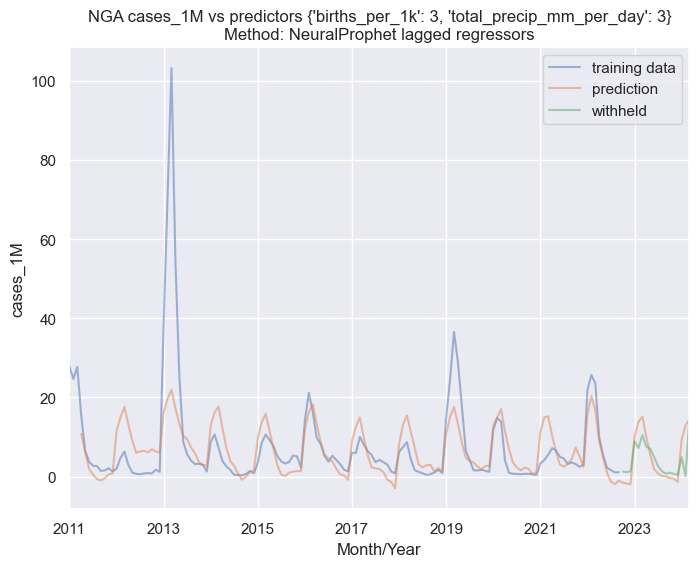

In [8]:
neuralRun = npLaggedTTS('NGA',
                        'cases_1M',
                        indepVars = {'total_precip_mm_per_day':3,
                                     'births_per_1k':3},
                        testSize = 18)

neuralRun.train()
plotTTS(neuralRun)
neuralRun.evaluate()

## Neural Prophet future regressors class 

In [9]:
class npFutureTTS:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337,
                 preprocessor = ep.tempConfigURL,
                 additionalPrep = dict()):
        """
        Initialize the model parameters
        """
        
        self.method = 'NeuralProphet future regressors'

        initModel(self,
                  country,
                  depVar,
                  indepVars,
                  projectionMethod,
                  testSize,
                  randomState,
                  preprocessor,
                  additionalPrep,
                  dict())

    
    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile):
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = NeuralProphet()
            
            for indepVar,delay in self.indepVars.items():
                model.add_future_regressor(indepVar)

            metrics = model.fit(self.trainDf,
                                freq='M')

            toMerge = pd.DataFrame(columns=['ds'])
            if self.features == []:
                future = model.make_future_dataframe(self.trainDf,
                                                     periods=self.testSize,
                                                     n_historic_predictions=True)
            else:
                future = self.trainDf.copy(deep=True)
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    toMerge = toMerge.merge(predictor,how='outer')
                    
            future = pd.concat([future,toMerge],
                               axis=0,
                               ignore_index=True)
            
            forecast = model.predict(future)
            result = {'train':self.trainDf,
                      'metrics':metrics,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast']['yhat1'][-self.testSize:].values
        self.yTrainPred = self.trained['forecast']['yhat1'][:-self.testSize].values
        standardizeOutput(self)


    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")

        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

{'Test MSE': 22.56263165618463,
 'Test MAE': 2.6573213587942592,
 'Test R2': -0.2621300397361599,
 'Train MSE': 91.46820386761483,
 'Train MAE': 4.32675610613829,
 'Train R2': 0.41914019389601576,
 'method': 'NeuralProphet future regressors',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'total_precip_mm_per_day': 4},
 'withheld': 12,
 'random state': 1337,
 'model args': '{}'}

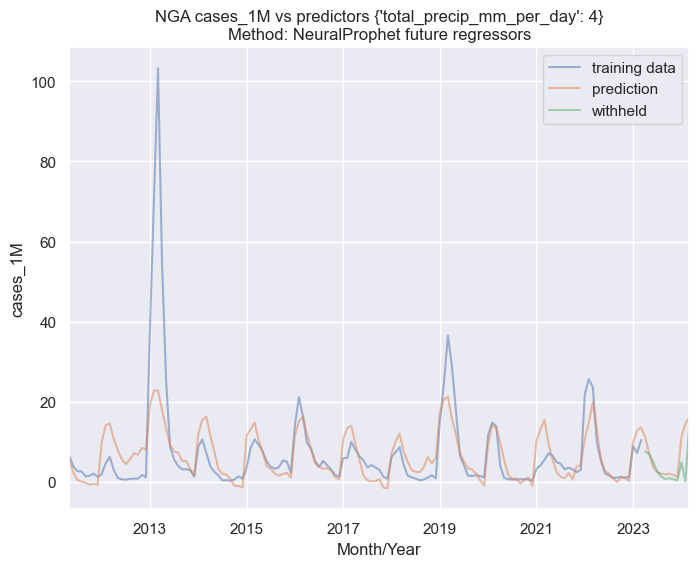

In [10]:
neuralRun = npFutureTTS('NGA',
                        'cases_1M',
                        indepVars = {'total_precip_mm_per_day':4},
                        testSize = 12)

neuralRun.train()
plotTTS(neuralRun)
neuralRun.evaluate()

## Scikit-learn gradient boosting regression trees class

In [11]:
class sklGradientBoostingRegression:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337,
                 preprocessor = ep.tempConfigURL,
                 additionalPrep = dict()):
        """
        Initialize the model parameters
        """
        
        self.method = 'Scikit-learn gradient boosted regression'

        initModel(self,
                  country,
                  depVar,
                  indepVars,
                  projectionMethod,
                  testSize,
                  randomState,
                  preprocessor,
                  additionalPrep,
                  dict())

    
    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile) and False:
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = GradientBoostingRegressor(random_state=self.randomState)
            model.fit(self.xTrain, self.yTrain)


            if self.features == []:
                raise ValueError("Model cannot be trained without one or more independent variables.")
            else:
                future = self.trainDf.copy(deep=True)
                toMerge = pd.DataFrame(columns=['ds'])
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    toMerge = toMerge.merge(predictor,how='outer')

            future = pd.concat([future,toMerge],
                               axis=0,
                               ignore_index=True)
            
            forecast = model.predict(future[sorted(list(self.features.keys()))].values)
            
            result = {'train':self.trainDf,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast'][-self.testSize:]
        self.yTrainPred = self.trained['forecast'][:-self.testSize]
        standardizeOutput(self)
    

    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")

        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

{'Test MSE': 29.134287757665078,
 'Test MAE': 4.7423310408248325,
 'Test R2': -0.6297416154993247,
 'Train MSE': 1.9651512801583417,
 'Train MAE': 1.001439870518711,
 'Train R2': 0.9875205006407487,
 'method': 'Scikit-learn gradient boosted regression',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'birth_per_1k': 3, 'total_precip_mm_per_day': 4},
 'withheld': 12,
 'random state': 1337,
 'model args': '{}'}

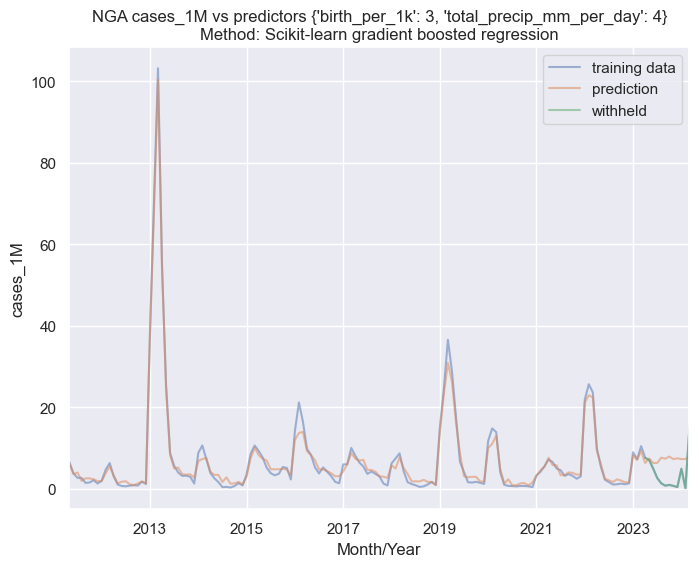

In [12]:
gbrRun = sklGradientBoostingRegression('NGA',
                                       'cases_1M',
                                       indepVars = {'total_precip_mm_per_day':4,
                                                   'birth_per_1k':3},
                                       testSize = 12)

gbrRun.train()
plotTTS(gbrRun)
gbrRun.evaluate()

## Scikit-learn generic regression wrapper class
* Many of these cause spurious python kernel crashes that try/except will not catch

In [13]:
class sklGeneric:
    def __init__(self,
                 country,
                 depVar,
                 indepVars,
                 projectionMethod = 'NeuralProphet autoregression',
                 testSize = 12,
                 randomState = 1337,
                 modelArgs = dict(),
                 preprocessor = ep.tempConfigURL,
                 additionalPrep = dict()):
        """
        Initialize the model parameters
        """
        
        self.method = f'Scikit-learn generic: {modelArgs["modelName"]}'
        
        initModel(self,
                  country,
                  depVar,
                  indepVars,
                  projectionMethod,
                  testSize,
                  randomState,
                  preprocessor,
                  additionalPrep,
                  modelArgs)

    
    def train(self):
        """
        Trains the model, loading from cache if previously trained
        """

        cacheFile = f'store/{self.hash}Trained.pkl'
        set_random_seed(self.randomState)
        
        if os.path.exists(cacheFile) and False:
            with open(cacheFile, 'rb') as fileIn:
                self.trained = pickle.load(fileIn)
        
        else:
            model = self.modelArgs['model'](random_state=self.randomState)
            model.fit(self.xTrain, self.yTrain)

            
            if self.features == []:
                raise ValueError("Model cannot be trained without one or more independent variables.")
            else:
                future = self.trainDf.copy(deep=True)
                toMerge = pd.DataFrame(columns=['ds'])
                for indepVar,delay in self.indepVars.items():
                    predictor = projectPredictor(self.trainDf,
                                                 indepVar,
                                                 self.testSize,
                                                 method = self.projection,
                                                 randomState = self.randomState)
                    toMerge = toMerge.merge(predictor,how='outer')

            future = pd.concat([future,toMerge],
                               axis=0,
                               ignore_index=True)
            
            forecast = model.predict(future[sorted(list(self.features.keys()))].values)
            
            result = {'train':self.trainDf,
                      'future':future,
                      'forecast':forecast,
                      'model':model,}
    
            with open(cacheFile, 'wb') as fileOut:
                pickle.dump(result, fileOut, protocol=pickle.HIGHEST_PROTOCOL)

            self.trained = result

        self.yTestPred = self.trained['forecast'][-self.testSize:]
        self.yTrainPred = self.trained['forecast'][:-self.testSize]
        standardizeOutput(self)

    
    def evaluate(self):
        """
        Returns evaluation data
        """
        if self.trained is None:
            raise ValueError("Model has not been trained yet, call that first.")

        results = evaluateModel(self)
        modelParams = {'method':self.method,
                       'predictor projection':self.projection,
                       'depVar':self.depVar,
                       'indepVars':self.features,
                       'withheld':self.testSize,
                       'random state':self.randomState,
                       'model args':str(self.modelArgs)}

        results.update(modelParams)
        return results

{'Test MSE': 8.216271878664793,
 'Test MAE': 2.3469339606006705,
 'Test R2': 0.5403903360776723,
 'Train MSE': 31.28924898492833,
 'Train MAE': 2.995933260272238,
 'Train R2': 0.8013007107384595,
 'method': 'Scikit-learn generic: Random Forest regressor',
 'predictor projection': 'NeuralProphet autoregression',
 'depVar': 'cases_1M',
 'indepVars': {'total_precip_mm_per_day': 4},
 'withheld': 12,
 'random state': 1337,
 'model args': "{'model': <class 'sklearn.ensemble._forest.RandomForestRegressor'>, 'modelName': 'Random Forest regressor'}"}

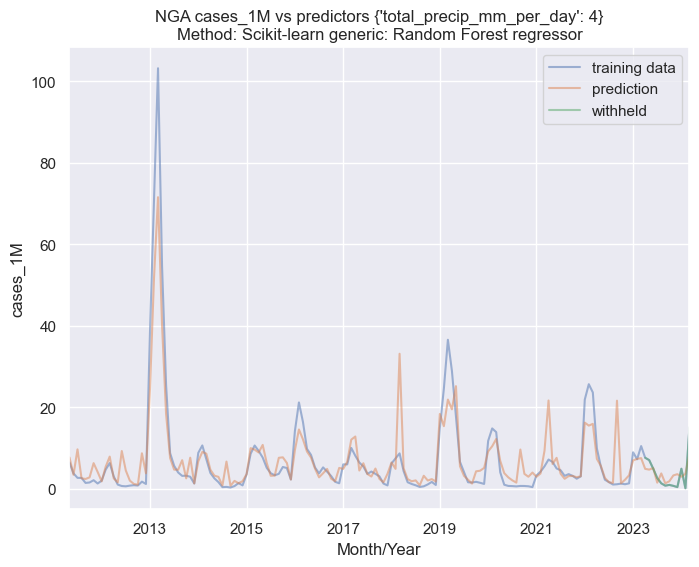

In [14]:
genericArgs = {'model':RandomForestRegressor,
             'modelName': 'Random Forest regressor'}

genericRun = sklGeneric('NGA',
                        'cases_1M',
                        indepVars = {'total_precip_mm_per_day':4},
                        modelArgs = genericArgs,
                        testSize = 12)

genericRun.train()
plotTTS(genericRun)
genericRun.evaluate()

# Examples

## Ensemble modelling method sweep via skl generic wrapper

In [15]:
import sklearn.ensemble
import inspect

members = inspect.getmembers(sklearn.ensemble, inspect.isclass)

regressorClasses = [{'modelName':name,
                     'model':cls} for name, cls in members if cls.__module__.startswith('sklearn.ensemble')]

toSkip = {'GradientBoostingRegressor','RandomForestRegressor'}


for regressorModelArgs in regressorClasses:
    modelName = regressorModelArgs['modelName']
    if modelName.endswith('Regressor') and modelName not in toSkip:
        try:
            print(f"Preparing to run {modelName}")
            genericRun = sklGeneric('NGA',
                                'cases_1M',
                                indepVars = {'total_precip_mm_per_day':3},
                                modelArgs = regressorModelArgs,
                                testSize = 12)
        
            print("Training....")
            genericRun.train()
            print("Evaluating...")
            result = genericRun.evaluate()
            print(result)
        except:
            print("Fails")
            pass
        print()

Preparing to run AdaBoostRegressor
Training....
Evaluating...
{'Test MSE': 31.929132304120674, 'Test MAE': 4.797063066842768, 'Test R2': -0.7860822991672018, 'Train MSE': 49.32202932245665, 'Train MAE': 5.721533816307453, 'Train R2': 0.6855420665639702, 'method': 'Scikit-learn generic: AdaBoostRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_precip_mm_per_day': 3}, 'withheld': 12, 'random state': 1337, 'model args': "{'modelName': 'AdaBoostRegressor', 'model': <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>}"}

Preparing to run BaggingRegressor
Training....
Evaluating...
{'Test MSE': 16.7314293452766, 'Test MAE': 2.987776790498033, 'Test R2': 0.06406132466341652, 'Train MSE': 35.350933537954546, 'Train MAE': 2.8766044229139327, 'Train R2': 0.7746162990840634, 'method': 'Scikit-learn generic: BaggingRegressor', 'predictor projection': 'NeuralProphet autoregression', 'depVar': 'cases_1M', 'indepVars': {'total_pre